## ECMWF ORAS5

In this notebook, we compute seasonal mean of SST and SSS using ORAS5 ocean reanalysis product. We then compute anomaly time series in the North Atlantic for comparison against DePreSys4 Hindcasts.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read Data

ppdir="../../../Data/ORAS5_Data/oras5/r1x1/"

ds_SST = []
ds_SSS = []
ds_mld = []
ds_heatflux = []

for r in range(0, 5):
    
    d = xr.open_mfdataset(ppdir + "sosstsst/opa" + str(r) + "/*.nc")
    ds_SST.append(d)
    
    d = xr.open_mfdataset(ppdir + "sosaline/opa" + str(r) + "/*.nc")
    ds_SSS.append(d)
    
    d = xr.open_mfdataset(ppdir + "somxl010/opa" + str(r) + "/*.nc")
    ds_mld.append(d)
    
    d = xr.open_mfdataset(ppdir + "sohefldo/opa" + str(r) + "/*.nc")
    ds_heatflux.append(d)
    
ds_SST = xr.concat(ds_SST, dim='r')
ds_SSS = xr.concat(ds_SSS, dim='r')
ds_mld = xr.concat(ds_mld, dim='r')
ds_heatflux = xr.concat(ds_heatflux, dim='r')

ds = xr.merge([ds_SST, ds_SSS, ds_heatflux, ds_mld])

print(ds)

<xarray.Dataset>
Dimensions:       (lat: 180, lon: 360, r: 5, time_counter: 480)
Coordinates:
  * lat           (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon           (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time_counter  (time_counter) datetime64[ns] 1979-01-16 ... 2018-12-16
Dimensions without coordinates: r
Data variables:
    sosstsst      (r, time_counter, lat, lon) float32 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    sosaline      (r, time_counter, lat, lon) float32 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    sohefldo      (r, time_counter, lat, lon) float32 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    somxl010      (r, time_counter, lat, lon) float32 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.4
    NCO:          4.4.6
    title:        Monthly mean 2D Sea Surface fields
    source:       ORAS5 - Ocean ReAnalysis System 5 (ECMWF)
    inst

In [3]:
# Read mask data and add gird deltas for area information
ds_mask = xr.open_dataset(ppdir + "LSM_r1x1/tmask2D_r1x1.nc")
ds_mask = ds_mask.isel(time=0, z=0) # This is to get rid of dimentions that are not requierd a size of time and z = 1. 

# Deltas to compute cell areas

RAD_EARTH = 6.387e6

d_lon, d_lat = (1.0, 1.0)

ds_mask['dx'] = ((d_lon * np.cos(ds_mask['lat'] * np.pi / 180.) 
                 * (2 * np.pi * RAD_EARTH / 360.)).expand_dims(lon=ds_mask.lon)).transpose('lat','lon')

ds_mask['dy'] = d_lat * (2 * np.pi * RAD_EARTH / 360.)
ds_mask['dy'] = ds_mask['dy'].expand_dims(lat=ds_mask.lat, lon=ds_mask.lon)

ds_mask['Area'] = ds_mask['dx'] * ds_mask['dy']

print(ds_mask)

<xarray.Dataset>
Dimensions:  (lon: 360, lat: 180)
Coordinates:
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
    time     float64 0.0
Data variables:
    tmask    (lat, lon) float32 ...
    dx       (lat, lon) float32 972.8 972.8 972.8 972.8 ... 972.8 972.8 972.8
    dy       (lat, lon) float64 1.115e+05 1.115e+05 ... 1.115e+05 1.115e+05
    Area     (lat, lon) float64 1.084e+08 1.084e+08 ... 1.084e+08 1.084e+08
Attributes:
    CDI:          Climate Data Interface version 1.8.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Wed Apr 24 12:32:54 2019: cdo remap,r360x180,w_t_r1x1.nc tm...
    NCO:          4.6.7
    CDO:          Climate Data Operators version 1.8.2 (http://mpimet.mpg.de/...


#### Seasonal Mean and Anomalies

First compute the mean seasonal cycle (Dec, 1979 - Feb, 2017), which is what we used for DePreSys4 hindcast. We will first focus on the DJF season for simplicity.  

Note that computing seasonal means from monthly averaged data requires assigning proper weights as the number of days are not the same for all months. Here, we follow the following example for computing seasonal mean.

http://xarray.pydata.org/en/stable/examples/monthly-means.html

In [4]:
# ds_clim can be mean over all ensembles or separate for each ensemble, check properly 
# does not make much difference. let's stick with ds_clim for each ensemble separately.

ds1 = ds.isel(time_counter=slice(11, 458)) # Just consider Dec, 1978 to Feb, 2017

# compute mean seasonality and anomlay suing proper weights
month_length = ds1.time_counter.dt.days_in_month # get number of days in months
weights = month_length.groupby("time_counter.season") / month_length.groupby("time_counter.season").sum()

ds_clim = (ds1 * weights).groupby('time_counter.season').sum('time_counter')

ds_resam = ((ds1 * weights).resample(time_counter='QS-DEC').mean('time_counter') 
            / weights.resample(time_counter='QS-DEC').mean('time_counter'))
ds_anom = ds_resam.groupby("time_counter.season") - ds_clim
#ds_anom = ds_anom.sel(time_counter = ds_anom['time_counter.season'] == 'DJF')

# compute mean, anomaly without using weights and isolate winter seasons only
ds1_clim = (ds1).groupby('time_counter.season').mean('time_counter')

ds1_resam = ds1.resample(time_counter='QS-DEC').mean('time_counter')
ds1_anom = ds1_resam.groupby("time_counter.season") - ds1_clim 
#ds1_anom = ds_anom.sel(time_counter = ds_anom['time_counter.season'] == 'DJF')

In [5]:
print(ds_clim)

<xarray.Dataset>
Dimensions:   (lat: 180, lon: 360, season: 4, r: 5)
Coordinates:
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: r
Data variables:
    sosstsst  (season, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    sosaline  (season, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    sohefldo  (season, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    somxl010  (season, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>


In [6]:
print(ds_anom, ds1_anom)

<xarray.Dataset>
Dimensions:       (time_counter: 149, lat: 180, lon: 360, r: 5)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1979-12-01 ... 2016-12-01
  * lat           (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon           (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
    season        (time_counter) <U3 'DJF' 'MAM' 'JJA' ... 'JJA' 'SON' 'DJF'
Dimensions without coordinates: r
Data variables:
    sosstsst      (time_counter, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    sosaline      (time_counter, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    sohefldo      (time_counter, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    somxl010      (time_counter, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray> <xarray.Dataset>
Dimensions:       (time_counter: 149, lat: 180, lon: 360, r: 5)
Coordinates:
  * time_co

In [7]:
print(ds_resam)

<xarray.Dataset>
Dimensions:       (time_counter: 149, lat: 180, lon: 360, r: 5)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 1979-12-01 ... 2016-12-01
  * lat           (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon           (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Dimensions without coordinates: r
Data variables:
    sosstsst      (time_counter, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    sosaline      (time_counter, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    sohefldo      (time_counter, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    somxl010      (time_counter, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>


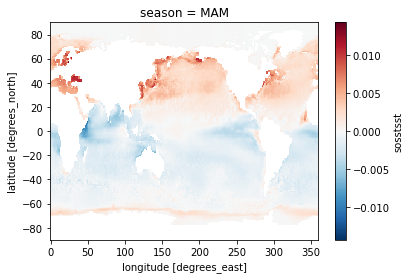

In [8]:
(ds_clim['sosstsst'].isel(r=0,season=2) - ds1_clim['sosstsst'].isel(r=0,season=2)).plot()

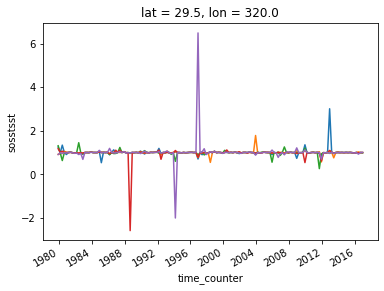

In [9]:
#ds_anom['sosstsst'].isel(r=0).sel(lat=29.5, lon=320.).plot()
#ds1_anom['sosstsst'].isel(r=0).sel(lat=29.5, lon=320.).plot()

# Just for check and mak esure that using weights does make some difference 
for i in range(0,5):
    (ds_anom['sosstsst'].isel(r=i).sel(lat=29.5, lon=320.) / 
     ds1_anom['sosstsst'].isel(r=i).sel(lat=29.5, lon=320.)).plot()

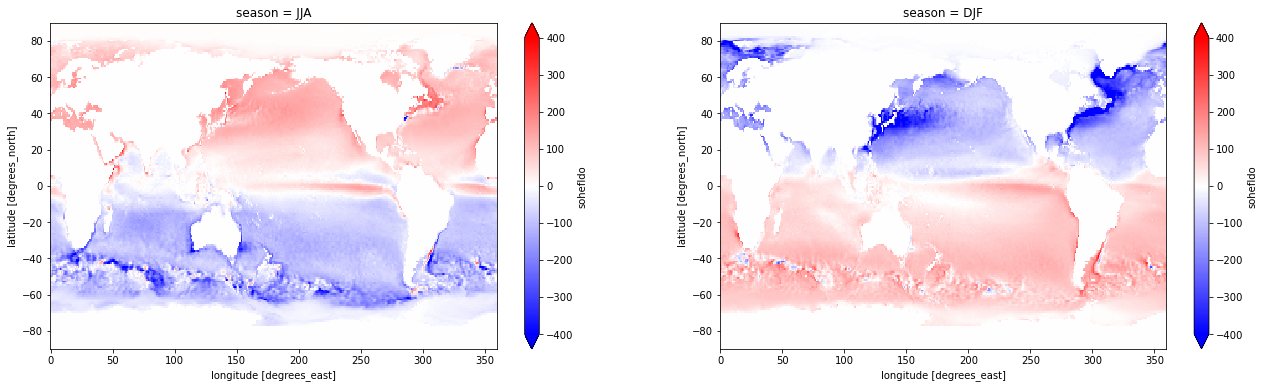

In [16]:
grid = plt.GridSpec(1, 2, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=[22,6])

seasons = ['JJA', 'DJF']

for i in range(0,len(seasons)):
    ax = fig.add_subplot(grid[0, i])
    ds_clim['sohefldo'].mean('r').sel(season=seasons[i]).plot(vmin=-400, vmax=400, cmap='bwr')

In [17]:
print(ds['sohefldo'])

<xarray.DataArray 'sohefldo' (r: 5, time_counter: 480, lat: 180, lon: 360)>
dask.array<concatenate, shape=(5, 480, 180, 360), dtype=float32, chunksize=(1, 1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat           (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon           (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time_counter  (time_counter) datetime64[ns] 1979-01-16 ... 2018-12-16
Dimensions without coordinates: r
Attributes:
    standard_name:       Net Downward Heat Flux
    long_name:           Net Downward Heat Flux
    units:               W/m2
    online_operation:    ave(x)
    interval_operation:  1200.0
    interval_write:      2678400.0
    offline_operation:   ave(x)


#### Area-mean anomalies in the North Atlantic

We compute area-weighted mean anomalies in the North Atlantic for comparison. For this, we choose three regions 0-40N, 40N-70N, and the whole North Atlantic. We need to create mask for North Atlamtic, so we use cmip6_prepocessing library. As seen below, mask = 0 is assinged for North Atlantic region.

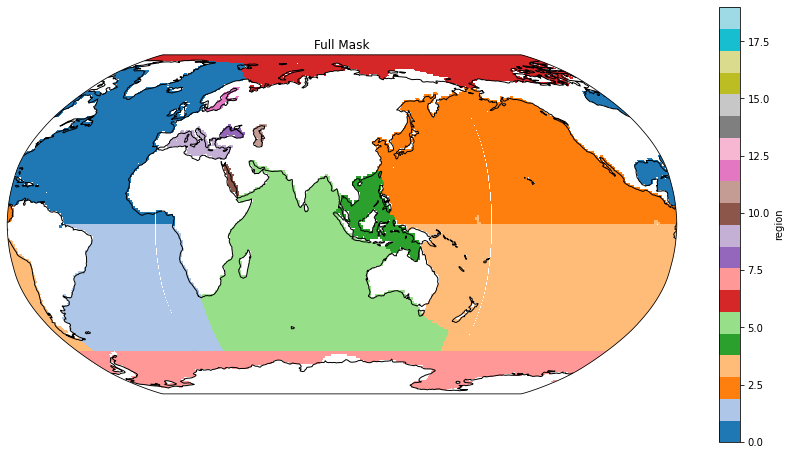

In [9]:
from cmip6_preprocessing.regionmask import merged_mask
import regionmask

basins = regionmask.defined_regions.natural_earth.ocean_basins_50

mask_NA = merged_mask(basins, ds_mask)

import cartopy.crs as ccrs

kwargs = dict(x='lon', y='lat',transform = ccrs.PlateCarree(), infer_intervals=False)

fig, ax = plt.subplots(ncols=1, figsize=[15,8], subplot_kw={'projection':ccrs.Robinson(100)})

mask_NA.plot(cmap='tab20', vmin=0, vmax=19, **kwargs)
ax.set_title(f"Full Mask")
ax.coastlines()

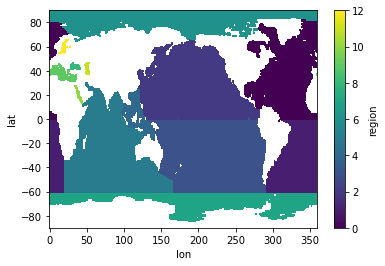

In [10]:
# just to make sure that lons are read correctly in cmip6_preprocessing library
mask_NA.plot()

In [24]:
# Compute are-weighted anomalies

def Compute_area_weighted_mean(ds, area, mask, lat = [0., 90.]): 
    
    tmp = ds.where(mask == 0.).sel(lat=slice(lat[0], lat[1]))
    dA = area.where(mask == 0.).sel(lat=slice(lat[0], lat[1]))
    
    tmp1 = (tmp*dA).sum(['lat', 'lon']) / dA.sum(['lat', 'lon']) 
    
    return tmp1

Trop_Anom = Compute_area_weighted_mean(ds_anom.where(ds_mask['tmask']), 
                                       ds_mask['Area'].where(ds_mask['tmask'] < 10.), mask_NA, lat = [0., 40.])

Subpolar_Anom = Compute_area_weighted_mean(ds_anom.where(ds_mask['tmask']), 
                                           ds_mask['Area'].where(ds_mask['tmask'] < 10.), mask_NA, lat = [40., 70.])

NorthAtl_Anom = Compute_area_weighted_mean(ds_anom.where(ds_mask['tmask']), 
                                           ds_mask['Area'].where(ds_mask['tmask'] < 10.), mask_NA, lat = [0., 80.])

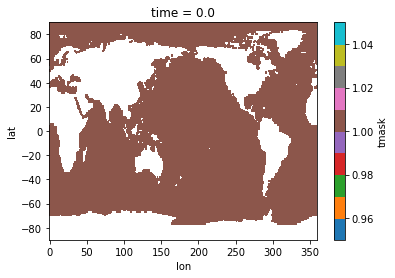

In [25]:
ds_mask['tmask'].plot(cmap='tab10')

In [26]:
Trop_Anom = Trop_Anom.compute()
Subpolar_Anom = Subpolar_Anom.compute()
NorthAtl_Anom = NorthAtl_Anom.compute()

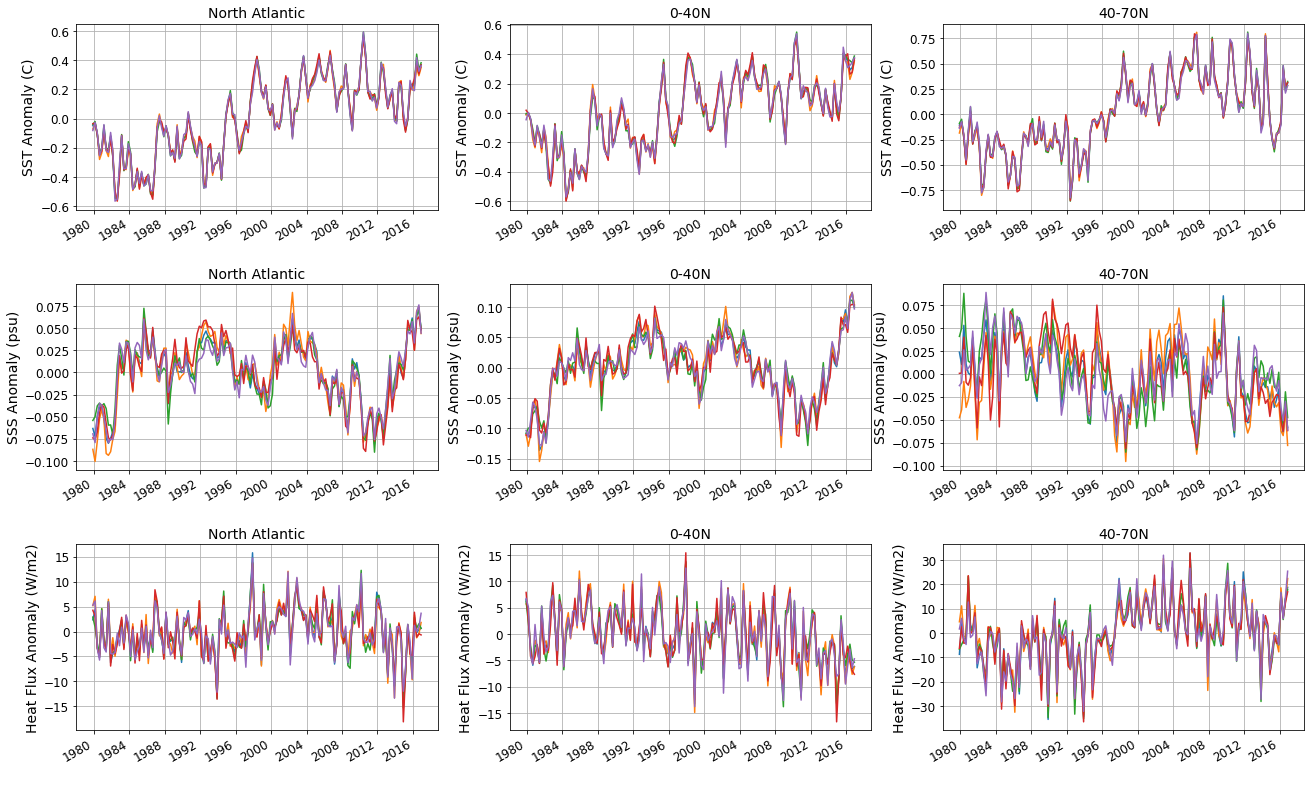

In [22]:
# remove ds_clim for each ensemble separately

grid = plt.GridSpec(3, 3, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=[22,13])

ax = fig.add_subplot(grid[0, 0])
for i in range(0,5):
    NorthAtl_Anom['sosstsst'].isel(r=i).plot()
    ax.set_ylabel(r'SST Anomaly (C)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('North Atlantic', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[0, 1])
for i in range(0,5):
    Trop_Anom['sosstsst'].isel(r=i).plot()
    ax.set_ylabel(r'SST Anomaly (C)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('0-40N', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[0, 2])
for i in range(0,5):
    Subpolar_Anom['sosstsst'].isel(r=i).plot()
    ax.set_ylabel(r'SST Anomaly (C)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('40-70N', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[1, 0])
for i in range(0,5):
    NorthAtl_Anom['sosaline'].isel(r=i).plot()
    ax.set_ylabel(r'SSS Anomaly (psu)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('North Atlantic', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[1, 1])
for i in range(0,5):
    Trop_Anom['sosaline'].isel(r=i).plot()
    ax.set_ylabel(r'SSS Anomaly (psu)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('0-40N', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[1, 2])
for i in range(0,5):
    Subpolar_Anom['sosaline'].isel(r=i).plot()
    ax.set_ylabel(r'SSS Anomaly (psu)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('40-70N', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[2, 0])
for i in range(0,5):
    NorthAtl_Anom['sohefldo'].isel(r=i).plot()
    ax.set_ylabel(r'Heat Flux Anomaly (W/m2)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('North Atlantic', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[2, 1])
for i in range(0,5):
    Trop_Anom['sohefldo'].isel(r=i).plot()
    ax.set_ylabel(r'Heat Flux Anomaly (W/m2)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('0-40N', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[2, 2])
for i in range(0,5):
    Subpolar_Anom['sohefldo'].isel(r=i).plot()
    ax.set_ylabel(r'Heat Flux Anomaly (W/m2)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('40-70N', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)

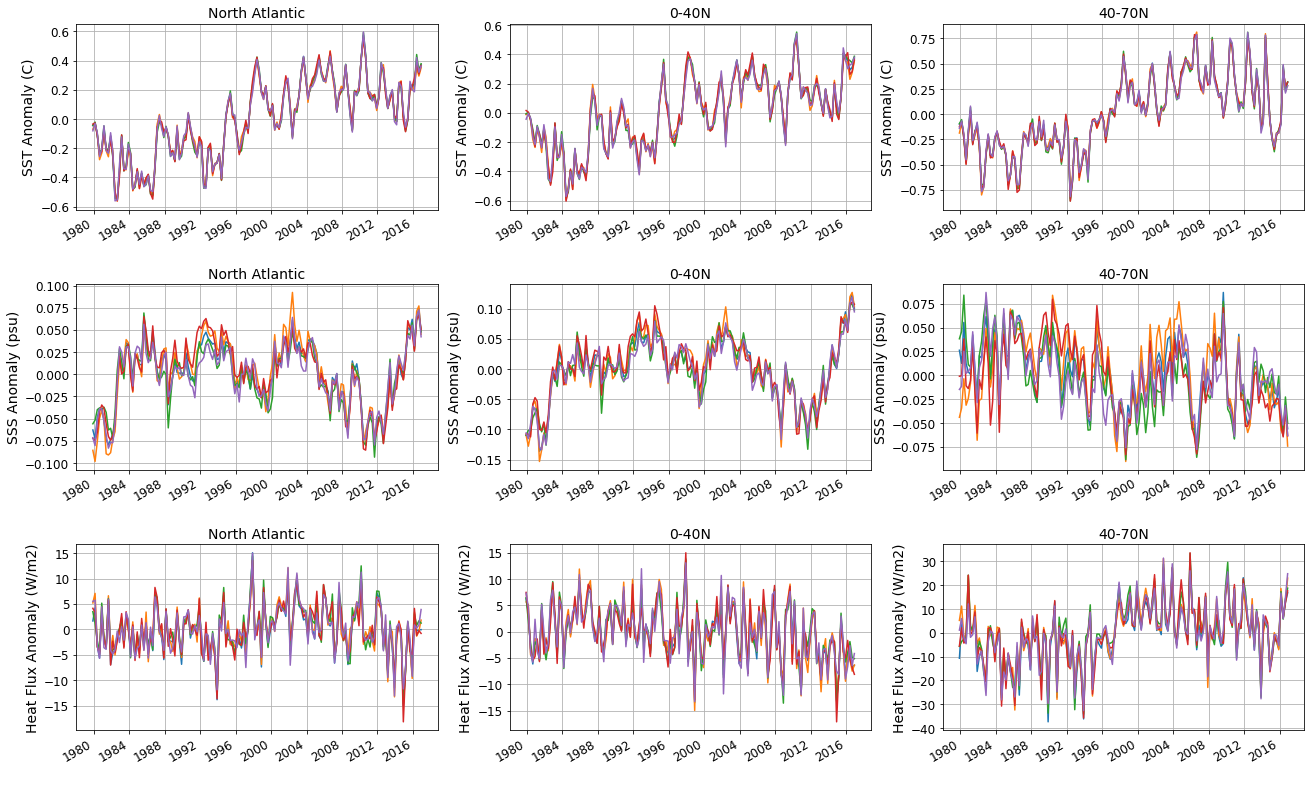

In [27]:
# ds_clim mean over all ensembles

grid = plt.GridSpec(3, 3, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=[22,13])

ax = fig.add_subplot(grid[0, 0])
for i in range(0,5):
    NorthAtl_Anom['sosstsst'].isel(r=i).plot()
    ax.set_ylabel(r'SST Anomaly (C)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('North Atlantic', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[0, 1])
for i in range(0,5):
    Trop_Anom['sosstsst'].isel(r=i).plot()
    ax.set_ylabel(r'SST Anomaly (C)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('0-40N', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[0, 2])
for i in range(0,5):
    Subpolar_Anom['sosstsst'].isel(r=i).plot()
    ax.set_ylabel(r'SST Anomaly (C)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('40-70N', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[1, 0])
for i in range(0,5):
    NorthAtl_Anom['sosaline'].isel(r=i).plot()
    ax.set_ylabel(r'SSS Anomaly (psu)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('North Atlantic', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[1, 1])
for i in range(0,5):
    Trop_Anom['sosaline'].isel(r=i).plot()
    ax.set_ylabel(r'SSS Anomaly (psu)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('0-40N', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[1, 2])
for i in range(0,5):
    Subpolar_Anom['sosaline'].isel(r=i).plot()
    ax.set_ylabel(r'SSS Anomaly (psu)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('40-70N', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[2, 0])
for i in range(0,5):
    NorthAtl_Anom['sohefldo'].isel(r=i).plot()
    ax.set_ylabel(r'Heat Flux Anomaly (W/m2)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('North Atlantic', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[2, 1])
for i in range(0,5):
    Trop_Anom['sohefldo'].isel(r=i).plot()
    ax.set_ylabel(r'Heat Flux Anomaly (W/m2)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('0-40N', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    
ax = fig.add_subplot(grid[2, 2])
for i in range(0,5):
    Subpolar_Anom['sohefldo'].isel(r=i).plot()
    ax.set_ylabel(r'Heat Flux Anomaly (W/m2)', fontsize=14)
    ax.set_xlabel(' ')
    ax.set_title('40-70N', fontsize=14)
    ax.grid()
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)

In [23]:
#save data 

save_path="../../../Data/ORAS5_Data/Drift_Anomaly/"

Trop_Anom.to_netcdf(save_path + 'Anomaly_T2D_Tropical.nc')
Subpolar_Anom.to_netcdf(save_path + 'Anomaly_T2D_Subpolar.nc')
NorthAtl_Anom.to_netcdf(save_path + 'Anomaly_T2D_NorthAtl.nc')

### Smaller ocean regions

In [13]:
def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.6) # orientation="horizontal"
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    ax.add_feature(cfeature.COASTLINE)
    #ax.add_feature(cfeature.LAND)
    ax.set_aspect(1.0)
    
    _ = plt.title(title, fontsize=14)
    return fig

In [14]:
print(ds_clim)

<xarray.Dataset>
Dimensions:   (lat: 180, lon: 360, season: 4, r: 5)
Coordinates:
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * season    (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: r
Data variables:
    sosstsst  (season, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    sosaline  (season, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    sohefldo  (season, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>
    somxl010  (season, r, lat, lon) float64 dask.array<chunksize=(1, 1, 180, 360), meta=np.ndarray>


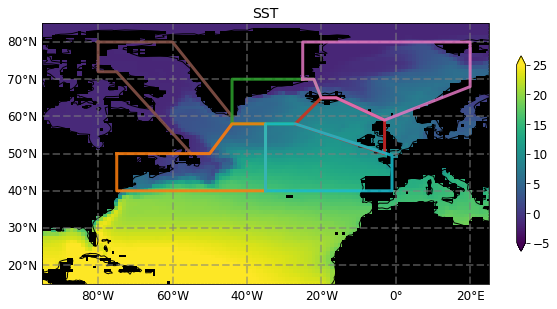

In [15]:
lat_lon_ext = [-95., 25., 15., 85.]
grid1 = plt.GridSpec(1, 1, wspace=0.15, hspace=0.3)
fig = plt.figure(figsize=[10,6])
    
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='black')

tmp = ds_clim['sosstsst'].isel(r=0,season=0).where(ds_mask['tmask']==1.) #.assign_coords({'lat': ds['latitude'], 'lon': ds['longitude']})
p = plot_sec(ax, tmp, vmin=-5., vmax=25., vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='viridis', title=r'SST')

# Add Labrador Sea Box

lab_y = [80., 72., 72., 50., 50., 58., 60., 80., 80.]
lab_x = [-80., -80, -75., -55., -50., -44., -44., -60., -80.] 
ax.plot(lab_x,lab_y, linestyle='-', lw = 3, color = 'tab:brown', alpha = 0.85, transform=ccrs.PlateCarree())

# Add Irminger Sea box
lab_y = [58., 70., 70., 65., 58., 58.]
lab_x = [-44., -44., -22., -20., -27., -44.]
ax.plot(lab_x,lab_y, linestyle='-', lw = 3, color = 'tab:green', alpha = 0.85, transform=ccrs.PlateCarree())

# Add Iceland Basin box
lab_y = [58., 65., 65., 59., 50., 58.]
lab_x = [-27., -20., -16., -3., -3., -27.]
ax.plot(lab_x,lab_y, linestyle='-', lw = 3, color = 'tab:red', alpha = 0.85, transform=ccrs.PlateCarree())

# Add NE box
lab_y = [70., 80., 80., 68., 59., 65., 65., 70., 70.]
lab_x = [-25., -25., 20., 20., -3., -16., -20., -22., -25.]
ax.plot(lab_x,lab_y, linestyle='-', lw = 3, color = 'tab:pink', alpha = 0.85, transform=ccrs.PlateCarree())

# Add SW region box
lab_y = [50., 40., 40., 58., 58., 50., 50.]
lab_x = [-75., -75., -35., -35., -44., -50., -75.]
ax.plot(lab_x,lab_y, linestyle='-', lw = 3, color = 'tab:orange', alpha = 0.85, transform=ccrs.PlateCarree())

# Add SE region box
lab_y = [40., 58., 58., 49.5, 40., 40.]
lab_x = [-35., -35., -27., -1., -1., -35.]
ax.plot(lab_x,lab_y, linestyle='-', lw = 3, color = 'tab:cyan', alpha = 0.85, transform=ccrs.PlateCarree())

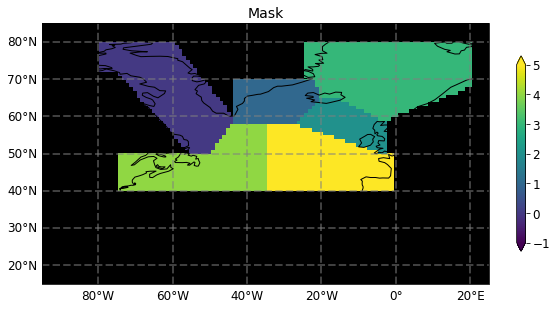

In [16]:
Labrador = np.array([[-80., -80, -75., -55., -50., -44., -44., -60., -80.], 
                     [80., 72., 72., 50., 50., 58., 60., 80., 80.]]).transpose()

Irminger = np.array([[-44., -44., -22., -20., -27., -44.], 
                   [58., 70., 70., 65., 58., 58.]]).transpose()

Iceland = np.array([[-27., -20., -16., -3., -3., -27.], 
                   [58., 65., 65., 59., 50., 58.]]).transpose()

North_east = np.array([[-25., -25., 20., 20., -3., -16., -20., -22., -25.], 
                       [70., 80., 80., 68., 59., 65., 65., 70., 70.]]).transpose()

South_west = np.array([[-75., -75., -35., -35., -44., -50., -75.], 
                       [50., 40., 40., 58., 58., 50., 50.]]).transpose()

South_east = np.array([[-35., -35., -27., -1., -1., -35.], 
                       [40., 58., 58., 49.5, 40., 40.]]).transpose()

names = ["Labrador Sea", "Irminger Sea", "Iceland Basin", "North East Region", "South West Region", 
         "South East Region"]

abbrevs = ["Lab", "Irm", "Ice", "NE", "SW", "SE"]

Ocean_Regions = regionmask.Regions([Labrador, Irminger, Iceland, North_east, South_west, South_east], 
                                   names=names, abbrevs=abbrevs, name="Subpolar North Atlantic")

mask_region = Ocean_Regions.mask(ds_clim.lon, ds_clim.lat)

lat_lon_ext = [-95., 25., 15., 85.]
grid1 = plt.GridSpec(1, 1, wspace=0.15, hspace=0.3)
fig = plt.figure(figsize=[10,6])
    
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='black')

tmp = mask_region.assign_coords({'lat': ds_clim['lat'], 'lon': ds_clim['lon']})
p = plot_sec(ax, tmp, vmin=-1., vmax=5., vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='viridis', title=r'Mask')

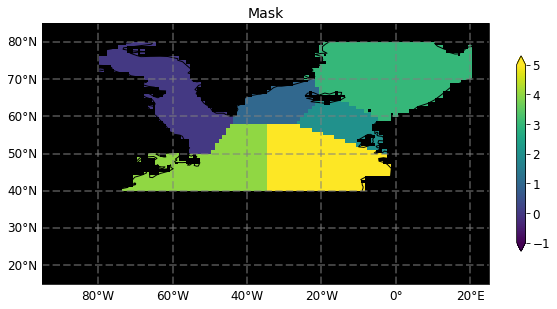

In [17]:
mask1 = mask_region.copy()

mask_region = mask1.where(ds_mask['tmask']==1.)

lat_lon_ext = [-95., 25., 15., 85.]
grid1 = plt.GridSpec(1, 1, wspace=0.15, hspace=0.3)
fig = plt.figure(figsize=[10,6])
    
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='black')

tmp = mask_region.assign_coords({'lat': ds_clim['lat'], 'lon': ds_clim['lon']})
p = plot_sec(ax, tmp, vmin=-1., vmax=5., vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='viridis', title=r'Mask')

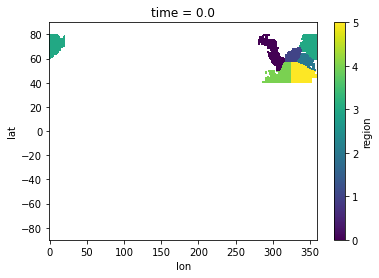

In [18]:
# just to make sure that lons are read correctly in regionmask library
mask_region.plot()

In [28]:
mask_save = xr.Dataset()

mask_save['mask_regions'] = mask_region.drop(['time'])

mask_save['mask_North_Atl'] = mask_NA

mask_save['area'] = ds_mask['Area'].where(ds_mask['tmask']==1.)

print(mask_save)

<xarray.Dataset>
Dimensions:         (lat: 180, lon: 360)
Coordinates:
  * lat             (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
    time            float64 0.0
Data variables:
    mask_regions    (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    mask_North_Atl  (lat, lon) float64 nan nan nan nan nan ... 6.0 6.0 6.0 6.0
    area            (lat, lon) float64 nan nan nan ... 1.084e+08 1.084e+08


In [29]:
region_list = ['Labrador_Sea', 'Irminger_Sea', 'Iceland_Basin', 'North_East_Region', 'South_West_Region', 
               'South_East_Region', 'North_Atlantic']

def Compute_area_weighted_mean(ds, area, mask, mask_val): 
    
    tmp = ds.where(mask == mask_val)
    dA = area.where(mask == mask_val)
    
    tmp1 = (tmp * dA).sum(['lat', 'lon']) / dA.sum(['lat', 'lon']) 
    
    return tmp1


anom_mean = []
for var in list(ds_anom.keys()):
    mask_val = 0.
    anom_save = xr.Dataset()

    for mask_region in region_list:

        if(mask_region == 'North_Atlantic'):
            area_weigh_val = Compute_area_weighted_mean(ds_anom[var].where(ds_mask['tmask']==1.), 
                                                        mask_save['area'], mask_save['mask_North_Atl'], 0.)
        else:
            area_weigh_val = Compute_area_weighted_mean(ds_anom[var].where(ds_mask['tmask']==1.), 
                                                        mask_save['area'], mask_save['mask_regions'], mask_val)
            mask_val = mask_val + 1

        anom_save[mask_region] = area_weigh_val

    anom_save = anom_save.compute()
    
    anom_mean.append(anom_save)
    
    # save file
    save_path="../../../Data/ORAS5_Data/Drift_Anomaly/"

    anom_save.to_netcdf(save_path + var + '.nc')

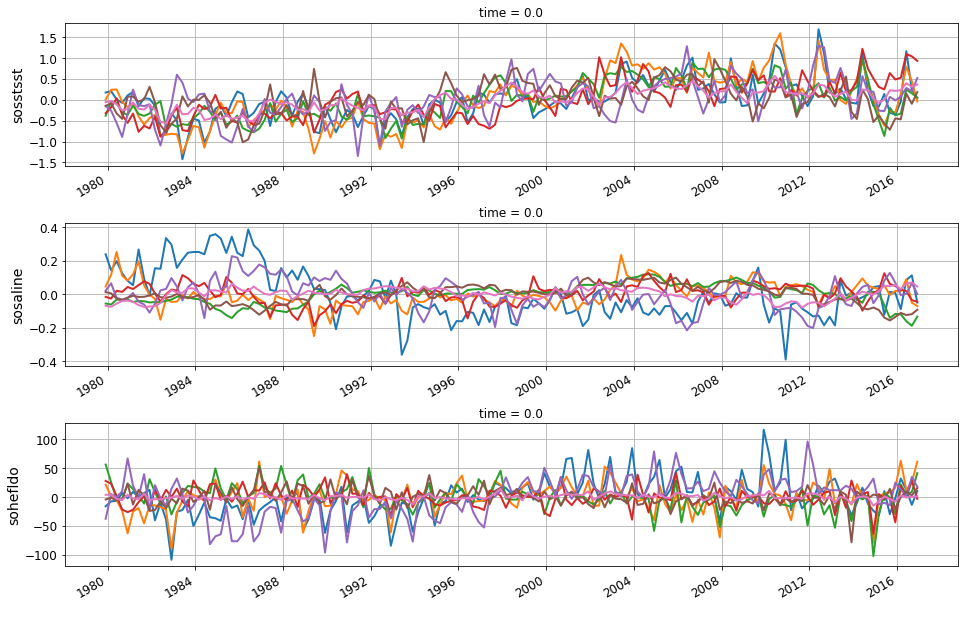

In [30]:
grid = plt.GridSpec(3, 1, wspace=0.2, hspace=0.4)
fig = plt.figure(figsize=[16,10])

for i in range(0,3):
    ax = fig.add_subplot(grid[i, 0])
    
    for mask_region in region_list[0:]:    
        anom_mean[i][mask_region].mean('r').plot(lw=2)
        ax.set_ylabel(list(ds_anom.keys())[i], fontsize=14)
        ax.set_xlabel(' ')
        #ax.set_title('40-70N', fontsize=14)
        ax.grid('on')
        plt.yticks(fontsize = 12)
        plt.xticks(fontsize = 12)